In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy import signal

# Configuración
data_folder = Path("datasavnet")
file_list = sorted(list(data_folder.glob("*.npy")))

#file_list = [f for f in os.listdir() if f.endswith('.txt')]  # Ejemplo para archivos binarios
archivosnum = len(file_list)
file_list


[WindowsPath('datasavnet/savnet_24h_p1.npy'),
 WindowsPath('datasavnet/savnet_24h_p2.npy'),
 WindowsPath('datasavnet/savnet_24h_p3.npy'),
 WindowsPath('datasavnet/savnet_24h_p4.npy')]

In [15]:


# Cargar datos (usar mmap si el archivo es grande)
# Alternativa con generator y concatenate (más eficiente en memoria)
datos_combinados = np.concatenate([np.load(f, mmap_mode="r") for f in file_list])
# Ver estructura básica
print("Tipo de datos:", type(datos_combinados))  # Debería ser numpy.ndarray
print("Forma (shape):", datos_combinados.shape)  # Dimensiones del array (ej: (1000,) o (100, 3))
print("Tipo de datos (dtype):", datos_combinados.dtype)  # Ej: float32, int16, complex64, etc.
print("Número de elementos:",datos_combinados.size)  # Cantidad total de elementos
print("Número de dimensiones:", datos_combinados.ndim)  # Ej: 1 (vector), 2 (matriz), etc.

# Mostrar los primeros 5 elementos (si es un vector)
print("Primeros 5 elementos:", datos_combinados[:5] if datos_combinados.ndim == 1 else datos_combinados[0, :5])


Tipo de datos: <class 'numpy.ndarray'>
Forma (shape): (8000006400,)
Tipo de datos (dtype): float32
Número de elementos: 8000006400
Número de dimensiones: 1
Primeros 5 elementos: [ 197.  160. -253.  762.  812.]


In [ ]:
#PRUEBA DE FASE
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
import os
from tqdm import tqdm  # Opcional para barra de progreso
# ---------- 1. CONFIGURACIÓN INICIAL ----------
# Crear directorio para resultados si no existe
if not os.path.exists('resultados'):
    os.makedirs('resultados')
    
# Parámetros del sistema
fs = 96000  # Hz
bit_rate = 200  # bits por segundo
Ns = int(fs / bit_rate)  # muestras por bit (480 muestras/bit)
fc = 24000  # Hz (portadora)
block_duration = 1  # segundos
block_size = fs * block_duration

# ---------- 2. CARGA DE DATOS ----------
limit= int(len(datos_combinados)/8)
signal = datos_combinados[0:limit]
    

In [23]:
import numpy as np
from scipy.signal import butter, lfilter
from tqdm import tqdm
###############################################################################################################################
###############################################################################################################################
###############################################################################################################################

def process_and_save_iq_separate(input_signal, fs, fc, cutoff, block_size, overlap, output_prefix):
    """
    Procesa la señal por bloques y guarda I y Q en dos archivos binarios separados.
    
    Args:
        input_signal: Señal de entrada (array o generador).
        fs: Frecuencia de muestreo.
        fc: Frecuencia de portadora.
        cutoff: Frecuencia de corte del filtro.
        block_size: Tamaño de cada bloque (muestras).
        overlap: Muestras de solapamiento.
        output_prefix: Prefijo para los archivos (ej. "output" -> "output_I.dat", "output_Q.dat").
    """
    # Diseñar filtro
    nyquist = fs / 2
    normalized_cutoff = cutoff / nyquist
    b, a = butter(5, normalized_cutoff, btype='low')

    # Abrir archivos binarios para I y Q
    with open(f"{output_prefix}_I.dat", 'wb') as f_I, open(f"{output_prefix}_Q.dat", 'wb') as f_Q:
        zi_I = np.zeros(max(len(a), len(b)) - 1)  # Estado inicial del filtro (I)
        zi_Q = np.zeros(max(len(a), len(b)) - 1)  # Estado inicial del filtro (Q)

        for i in tqdm(range(0, len(input_signal), block_size - overlap)):
            start = i
            end = start + block_size
            if end > len(input_signal):
                end = len(input_signal)

            # Procesar bloque actual
            block = input_signal[start:end]
            t_block = (start + np.arange(len(block))) / fs

            # Demodulación IQ
            I_raw_block = block * np.cos(2 * np.pi * fc * t_block)
            Q_raw_block = block * -np.sin(2 * np.pi * fc * t_block)

            # Filtrado
            I_filtered_block, zi_I = lfilter(b, a, I_raw_block, zi=zi_I)
            Q_filtered_block, zi_Q = lfilter(b, a, Q_raw_block, zi=zi_Q)

            # Determinar qué parte guardar (manejar solapamiento)
            if i == 0:
                save_start = 0
                save_end = len(I_filtered_block)
            else:
                save_start = overlap
                save_end = len(I_filtered_block)

            # Escribir datos al archivo correspondiente
            I_filtered_block[save_start:save_end].tofile(f_I)
            Q_filtered_block[save_start:save_end].tofile(f_Q)

    print(f"Datos guardados en {output_prefix}_I.dat y {output_prefix}_Q.dat")

# Parámetros
fs = 96000
fc = 24000
cutoff = 300  # Hz
block_size = 1 * fs  # Bloques de 10 segundos
overlap = 1024  # Muestras de solapamiento


#data=datos_combinados;
# Procesar y guardar
process_and_save_iq_separate(
    input_signal=datos_combinados,
    fs=fs,
    fc=fc,
    cutoff=cutoff,
    block_size=block_size,
    overlap=overlap,
    output_prefix="filtered_IQ"
)

100%|███████████████████████████████████████████████████████████████████████████| 84232/84232 [09:31<00:00, 147.32it/s]


Datos guardados en filtered_IQ_I.dat y filtered_IQ_Q.dat


In [25]:
import numpy as np
from scipy.signal import butter, lfilter
from tqdm import tqdm

# --- Parámetros ---
fs = 96000  # Tasa de muestreo (Hz)
fc = 24000   # Frecuencia de portadora (Hz)
Rb = 200     # Tasa de bits (bps)
cutoff = 500 # Frecuencia de corte del filtro (Hz)
# --- Cálculo de constantes ---
I_filtered = np.memmap('filtered_IQ_I.dat', dtype=np.float64, mode='r')
Q_filtered = np.memmap('filtered_IQ_Q.dat', dtype=np.float64, mode='r')
# mmapped = np.memmap(filename, dtype=dtype, mode='r')

print('Archivos cargados');
samples_per_second = fs  # Muestras por segundo (100000)
num_seconds = len(I_filtered) // samples_per_second  # Número de segundos completos
# --- Inicialización de variables ---
amplitude_per_second = []
fase_IQ_delta_por_segundo = []
fase_IQ_delta_promedio_all = []
IQ_anterior = None  # Inicialmente no hay segmento anterior


# --- Procesamiento por segundo ---
for i in tqdm(range(num_seconds-1)):  # range(num_seconds) va desde 0 hasta num_seconds-1
    start = int(i * samples_per_second)
    end = int((i + 1) * samples_per_second)  
   
    #start = int(indices_filtrados[i])
    #end = int(indices_filtrados[i+1])
 
    # Segmento actual de IQ
    IQ_tmp = I_filtered[start:end] + 1j * Q_filtered[start:end]
    
    # --- Cálculo de amplitud promedio ---
    amplitude = np.abs(IQ_tmp)
    amp_avg = np.mean(amplitude)
    amplitude_per_second.append(amp_avg)
    
    # --- Cálculo de fase delta (solo si no es el primer segmento) ---
    if IQ_anterior is not None:
        #fase_IQ_delta = IQ_tmp * np.conj(IQ_anterior)
        #fase_IQ_delta_Angle= np.angle(fase_IQ_delta)
        
        #fase_IQ_delta_promedio = np.mean(np.exp(1j * np.angle(fase_IQ_delta)))  # Promedio complejo
        # Corrección del componente DC (promedio de los bins adyacentes)
        #fase_IQ_delta_Angle[0] = (fase_IQ_delta_Angle[1] + fase_IQ_delta_Angle[-1]) / 2
        fase_IQ_delta_promedio = np.mean(np.exp(1j * np.angle(IQ_tmp)))  # Promedio complejo
        fase_IQ_delta_angulo = np.angle(fase_IQ_delta_promedio)  # Fase promedio en radianes
        fase_IQ_delta_por_segundo.append(fase_IQ_delta_angulo)
        fase_IQ_delta_promedio_all.append(fase_IQ_delta_promedio)
    # Actualizar el segmento anterior para la próxima iteración
    IQ_anterior = IQ_tmp

# --- Guardado de resultados ---
np.save('amplitud_por_segundo_24K.npy', np.array(amplitude_per_second))
np.save('fase_por_segundo_24K.npy', np.array(fase_IQ_delta_por_segundo))
np.save('fase_por_segundo_IQ_24K.npy', np.array(fase_IQ_delta_promedio_all))

Archivos cargados


100%|████████████████████████████████████████████████████████████████████████████| 83332/83332 [16:07<00:00, 86.13it/s]


OSError: [Errno 22] Invalid argument: 'amplitud_por_segundo_pps.npy'

In [26]:
# --- Guardado de resultados ---
np.save('amplitud_por_segundo_24K.npy', np.array(amplitude_per_second))
np.save('fase_por_segundo_24K.npy', np.array(fase_IQ_delta_por_segundo))
np.save('fase_por_segundo_IQ_24K.npy', np.array(fase_IQ_delta_promedio_all))

In [27]:
# Cargar el archivo I/Q usando memmap para grandes archivos
#phaset = np.load(input_file, mmap_mode='r')
import numpy as np
import matplotlib.pyplot as plt

IQ_PHASE=np.load('amplitud_por_segundo_24k.npy', mmap_mode="r")
fase_IQ_delta = IQ_PHASE[1:] * np.conj(IQ_PHASE[:-1])


delta_phi = np.angle(fase_IQ_delta)  # Diferencia de fase entre segmentos
delta_phi_acc= delta_phi - delta_phi[0];
sumaacc = np.cumsum(delta_phi_acc)
relative_phase = np.cumsum(fase_IQ_delta)
angle_relative_phase=(np.angle(relative_phase))

x = np.arange(len(sumaacc))
coef = np.polyfit(x, sumaacc, 1)  # Ajuste lineal: pendiente y offset
trend = np.polyval(coef, x)
detrended_phase = sumaacc - trend


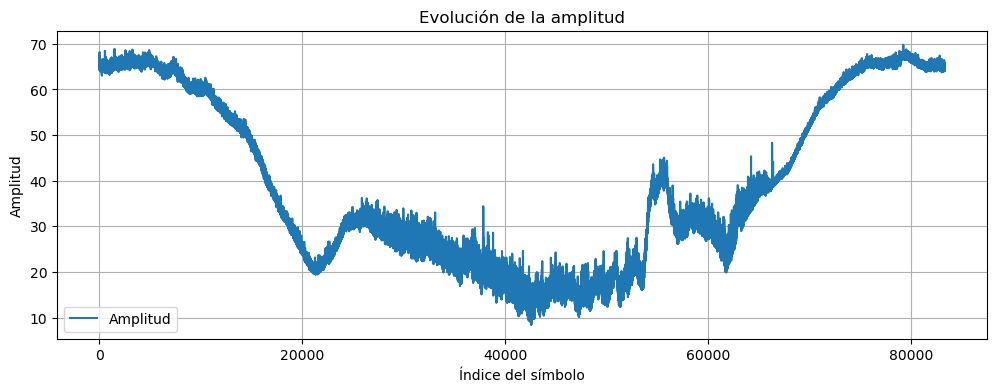

In [28]:

# Gráficas
plt.figure(figsize=(12, 4))
plt.plot(IQ_PHASE, label="Amplitud")
plt.xlabel("Índice del símbolo")
plt.ylabel("Amplitud")
plt.title("Evolución de la amplitud")
plt.grid(True)
plt.legend()
plt.show()





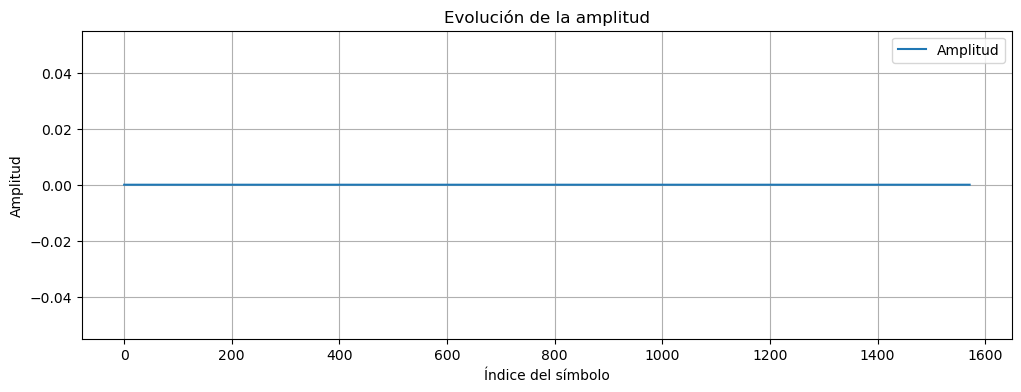

In [12]:
# Gráficas
plt.figure(figsize=(12, 4))
plt.plot(sumaacc, label="Amplitud")
plt.xlabel("Índice del símbolo")
plt.ylabel("Amplitud")
plt.title("Evolución de la amplitud")
plt.grid(True)
plt.legend()
plt.show()